## Import qiskit and check version

In [4]:
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
print(f"Current qiskit version: {qiskit.__version__}")

Current qiskit version: 1.4.0


In [ ]:
QiskitRuntimeService.saved_accounts()

{'default-ibm-quantum': {'channel': 'ibm_quantum',
  'url': 'https://auth.quantum.ibm.com/api',
  'token': '7a5b8bbfe93c428cd6ad258e87dcc03e0976069d6888676f3dfeba59ec78ff9ebeec1f6becddef41b8ed953ca2cf5648b725a902fa99b486017e038e56712f0f',
  'verify': True,
  'private_endpoint': False}}

### Connecting to IBM Service.

If this is your first time connecting to IBM Runtime Service, you should obtain an `API token` from IBM.

Next, run the code below.

In [ ]:
API_token = "Your_API_Token_goes_here"

RuntimeService = QiskitRuntimeService(channel="ibm_quantum"
                                    ,token = API_token)

QiskitRuntimeService.save_account(channel="ibm_quantum"
                                ,token = API_token
                                ,overwrite = True)


# For all future usage, simply do the following.
from qiskit_ibm_runtime import QiskitRuntimeService
RuntimeService = QiskitRuntimeService(channel="ibm_quantum")

### Connecting to a specific IBM quantum device.

You can choose your desired quantum backend to connect to.

In [ ]:

# backend = RuntimeService.backend("ibm_brisbane")
# backend.num_qubits

## Qiskit workflow

### Example using a 2-qubit circuit

#### Step 1: Map the problem to a quantum circuit

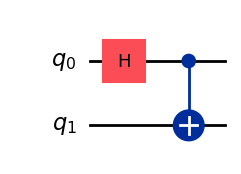

In [14]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0) # hadamat gate on qubit 0
qc.cx(0, 1) # controlled x gate on qubits 0 and 1

qc.draw(output='mpl')

# This is the Bell state

In [ ]:
# Choosing observables to measure. 

from qiskit.quantum_info import Pauli

ZZ = Pauli("ZZ")
ZI = Pauli("ZI") # Z on qubit 1, I on qubit 0
IZ = Pauli("IZ")
XX = Pauli("XX")
XI = Pauli("XI")
IX = Pauli("IX")

obs = [ZZ, ZI, IZ, XX, XI, IX]

#### Step 2: Optimize the circuit

To optimize the overall depth of the circuit, we need to consider

1. Local connectivity between qubits

2. Native gate sets, or ISA (Instruction Set Architecture) of the device

Qiskit offers a customizable `transpiler` (also called compiler) to optimize the quantum circuit for specific quantum hardware.

In qiskit, the `transpiler` is implemented using `pass_manager`. 

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=2, backend = None, target=None)

qc_transiled = pm.run(qc)

# Applying layout to observables
operators_transiled_list = [op.apply_layout(qc_transiled.layout) for op in obs]

#### Step 3: Execute the circuit on a backend


In [ ]:
from qiskit_aer.primitives import Estimator, EstimatorV2, Sampler, SamplerV2

estimator = Estimator()

job = estimator.run([qc]*len(obs), obs)

# Alternatively, since we have 6 circuits and 6 observables, we can use the following
job = estimator.run([qc, qc, qc, qc, qc, qc], obs)

job.result()

EstimatorResult(values=array([ 1.        ,  0.01171875,  0.01171875,  1.        , -0.03515625,
       -0.03515625]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.002672, 'sample_measure_time': 0.0008812, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 40133, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9998626708984375, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.002672, 'sample_measure_time': 0.000881

#### Step 4: Post process the results

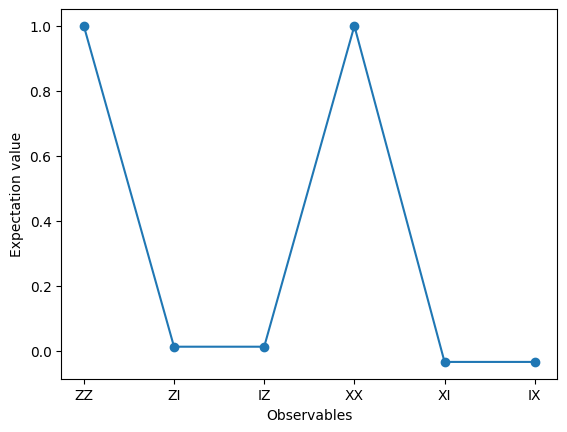

In [57]:
import matplotlib.pyplot as plt

data =["ZZ", "ZI", "IZ", "XX", "XI", "IX"]
values = job.result().values

plt.plot(data,values,"-o") # "-o" means solid line and circle as points
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()